### Imports

In [22]:
import sympy as sym
import numpy as np
from numpy.random import randn # Gaussian random number
import matplotlib.pyplot as plt

### Derivative of y

In [23]:
x1, x2 = sym.symbols('x1 x2') 

n = 200
sigma = 10
sigma2 = 2*sigma**2
lam = 0.000001

m = 20
w = randn(m)/sigma
b = np.random.rand(m)*2*np.pi

x = randn(n)/2
x1_example = randn(n)/2
x2_example = randn(n)/2
noise = randn(n) *2e-1

#y1 = 1+ sym.sin(x1/10) + x1**2 + noise
y1 = 1 + sym.sin(x1)
y2 = 0.5 * x2**2 + sym.exp(x2)

y1_normal = sym.lambdify(x1, y1, 'numpy') 
y2_normal = sym.lambdify(x2, y2, 'numpy')

y1_normal = y1_normal(x1_example) + noise
y2_normal = y2_normal(x2_example) + noise

# derivate y1, y2 with respect to x1, x2 (sympy)
y1_diff = y1.diff(x1)
y2_diff = y2.diff(x2)

# Put back to numpy functions
y1_derivative = sym.lambdify(x1, y1_diff, 'numpy') 
y2_derivative = sym.lambdify(x2, y2_diff, 'numpy')

# Apply derivative functions to the x-arrays that we have in the beginning
y1_derivative = y1_derivative(x1_example)
y2_derivative = y2_derivative(x2_example)

y_derivative = np.array(np.ravel([y1_derivative, y2_derivative], 'F'))

### Gaussian kernel

In [24]:
def k_gauss(x, z): 
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def K_gauss(x, y, n):
    Kxy = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            Kxy[i, j] = k_gauss(x[i], y[j])
    return Kxy

def alpha_gauss(x, y, n):
    K = K_gauss(x, x, n)
    return np.linalg.inv(K + lam*np.eye(n)) @ y

def function_gauss(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss(x_sort[i], x[j])
        f[i] = sum
    return f

alpha_ = alpha_gauss(x1_example, y1_normal, n)
func = function_gauss(x1_example, n, alpha_)

### Gradient of f

In [25]:
# x,z = [x[:,i], x[:,j]]
# sym.exp(-((sym.sqrt(sympv.dot(x-z, x-z)))**2)/(2*sigma**2)) (with sympy)
#def k_gauss(x, z):
#    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
#    return k

# Derivative of the gaussian kernel w.r.t. x
def k_gauss_derivative_wrt_x(x, z):
    kernel_gauss = k_gauss(x, z) # I formel er x - z tall, ikke vektorer
    k_derivative = -(kernel_gauss*(x-z)/sigma**2)
    return k_derivative

# Derivative of the gaussian kernel w.r.t. x and z
def k_gauss_derivative_wrt_x_and_z(x, z):
    kernel_gauss = k_gauss(x, z)
    k_derivative = -((x-z)**2-sigma**2)/(kernel_gauss*sigma**4)
    return k_derivative

def K_gauss_derivative_wrt_x(x, z, n):
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k_gauss_derivative_wrt_x(x[i], z[j])
    return K
    
# Alpha for gauss_kernel with respect to x
def alpha_gauss_derivative(x, y, n):
    K = K_gauss_derivative_wrt_x(x, x, n)
    return np.linalg.inv(K + lam*np.eye(n)) @ y

def func_gauss_derivative(x, n, alpha):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(n):
            sum = sum + alpha[j] * k_gauss_derivative_wrt_x(x_sort[i], x[j])
        f[i] = sum
    return f

alpha = alpha_gauss_derivative(x1_example, y1_derivative, n)
func_der = func_gauss_derivative(x1_example, n, alpha)

### Plotting

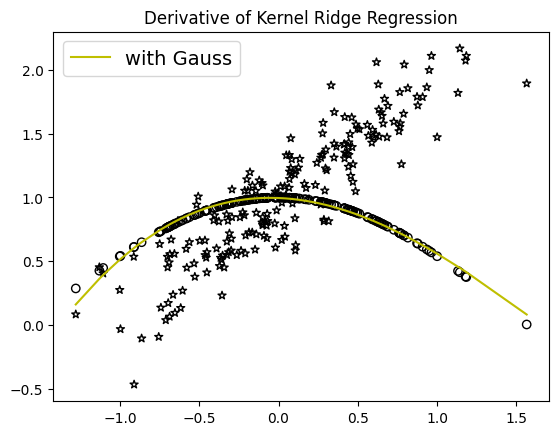

In [26]:
x1_sort = np.sort(x1_example)

plt.scatter(x1_example, y1_derivative, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.scatter(x1_example, y1_normal, facecolors ='none' , edgecolors = "k" , marker = "*")
plt.plot(x1_sort, func_der, c="y", label="with Gauss")
#plt.plot(x1_sort, func, c="b", label ="Normal")
plt.title("Derivative of Kernel Ridge Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()

### Random Fourier Features

In [27]:
# Using approximation 1
def psi(x, w, b):
    return np.sqrt(2)*np.cos(w*x + b)

def psi_derivative(x, w, b):
    return -np.sqrt(2)*w*np.sin(w*x+b)

def k_approx1_derivative(x_i, z_i, w, b, m):
    return 1/m * np.sum(psi_derivative(x_i, w, n) * psi(z_i, w, b))

def alpha_approx1_derivative(x, y, lam, w, b, m):
    K_derivative = np.zeros((n, m))
    for i in range(n):
        K_derivative[i, :] = psi_derivative(x[i], w, b)
    return np.linalg.inv(K_derivative.T @ K_derivative + lam*np.eye(m)) @ K_derivative.T @ y

def function_approx1_derivative(x, n, alpha, w, b):
    x_sort = np.sort(x)
    f = np.zeros(n)
    for i in range(n):
        f[i] = np.sum(alpha*psi_derivative(x_sort[i], w, b))
    return f

alpha_approx = alpha_approx1_derivative(x1_example, y1_derivative, lam, w, b, m)
func_approx = function_approx1_derivative(x1_example, n, alpha_approx, w, b)

### Plot

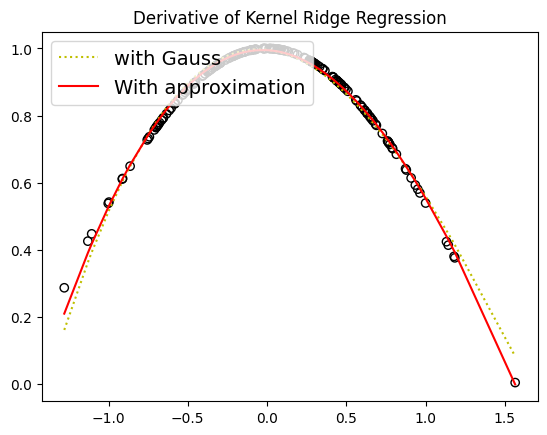

In [28]:
plt.scatter(x1_example, y1_derivative, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(x1_sort, func_der, c="y", label="with Gauss", ls = ":")
plt.plot(x1_sort, func_approx, c="r", label = "With approximation")
plt.title("Derivative of Kernel Ridge Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
plt.show()